In [1]:
import pandas as pd
import numpy as np 
import glob
from tqdm import tqdm
import sys
import os
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

files = sorted(glob.glob("../../data/Targets/high_10m/*.csv.gz"))
files

['../../data/Targets/high_10m\\20211201.csv.gz',
 '../../data/Targets/high_10m\\20211202.csv.gz',
 '../../data/Targets/high_10m\\20211203.csv.gz',
 '../../data/Targets/high_10m\\20211206.csv.gz',
 '../../data/Targets/high_10m\\20211207.csv.gz',
 '../../data/Targets/high_10m\\20211208.csv.gz',
 '../../data/Targets/high_10m\\20211209.csv.gz',
 '../../data/Targets/high_10m\\20211210.csv.gz',
 '../../data/Targets/high_10m\\20211213.csv.gz',
 '../../data/Targets/high_10m\\20211214.csv.gz',
 '../../data/Targets/high_10m\\20211215.csv.gz',
 '../../data/Targets/high_10m\\20211216.csv.gz',
 '../../data/Targets/high_10m\\20211217.csv.gz',
 '../../data/Targets/high_10m\\20211220.csv.gz',
 '../../data/Targets/high_10m\\20211221.csv.gz',
 '../../data/Targets/high_10m\\20211222.csv.gz',
 '../../data/Targets/high_10m\\20211223.csv.gz',
 '../../data/Targets/high_10m\\20211227.csv.gz',
 '../../data/Targets/high_10m\\20211228.csv.gz',
 '../../data/Targets/high_10m\\20211229.csv.gz',
 '../../data/Targets

In [2]:
days = []

for fn in tqdm(files, desc= "Reading files"):
    day = pd.read_csv(fn, compression= "gzip", parse_dates= ["DATE"])
    days.append(day)

df = pd.concat(days, ignore_index= True)

Reading files: 100%|██████████| 22/22 [00:03<00:00,  5.58it/s]


In [3]:
df = df.drop(columns= ["ALL_EX", "SUM_DELTA"]) #not needed
print("Shape of the data: ", df.shape)
print("Number of stocks: ", df["SYMBOL"].nunique())
df.sort_values(["SYMBOL", "DATE", "TIME"])
df

Shape of the data:  (6156358, 4)
Number of stocks:  9509


,DATE,SYMBOL,TIME,MID_OPEN
0,2021-12-01,A,09:30:00,152.190
1,2021-12-01,A,09:40:00,150.490
2,2021-12-01,A,09:50:00,151.475
3,2021-12-01,A,10:00:00,150.510
4,2021-12-01,A,10:10:00,151.960
...,...,...,...,...
6156353,2021-12-31,ZYXI,15:00:00,10.055
6156354,2021-12-31,ZYXI,15:10:00,10.040
6156355,2021-12-31,ZYXI,15:20:00,10.040
6156356,2021-12-31,ZYXI,15:30:00,10.010


### IF WE WANT TO TRADE DAILY AND NOT CARE ABOUT THE OVERNIGHT SHIFT, WE CALCULATE THE RETURN ON THE DAILY BASIS, MEANING I GROUPBY THE DATE AND WE START WITH A RETURN OF 0 EVERY DAY, WE CAN CHANGE THIS IN THE FUTURE

In [4]:
# Calculate the return on the column MID_OPEN, for each stock "SYMBOL" and on each day "DATE"
df["LIN_RETURN"] = (df.groupby(["SYMBOL", "DATE"])["MID_OPEN"].pct_change()) # Best way to calcuate the return
df["LIN_RETURN"] = df["LIN_RETURN"].fillna(0)


#TODO: log return
#print(np.log(150.490/152.190))

In [5]:
# SAVE THE PARQUET IN THE DATA FOLDER FOR EASY ACCESS NEXT TIME

df.to_parquet("../../data/high_10m.parquet", index = False)

In [6]:
df = pd.read_parquet("../../data/high_10m.parquet")
df

,DATE,SYMBOL,TIME,MID_OPEN,LIN_RETURN
0,2021-12-01,A,09:30:00,152.190,0.000000
1,2021-12-01,A,09:40:00,150.490,-0.011170
2,2021-12-01,A,09:50:00,151.475,0.006545
3,2021-12-01,A,10:00:00,150.510,-0.006371
4,2021-12-01,A,10:10:00,151.960,0.009634
...,...,...,...,...,...
6156353,2021-12-31,ZYXI,15:00:00,10.055,-0.006914
6156354,2021-12-31,ZYXI,15:10:00,10.040,-0.001492
6156355,2021-12-31,ZYXI,15:20:00,10.040,0.000000
6156356,2021-12-31,ZYXI,15:30:00,10.010,-0.002988


count    6.156358e+06
mean    -6.427697e-05
std      6.527531e-03
min     -3.551797e-01
25%     -1.176471e-03
50%      0.000000e+00
75%      1.121076e-03
max      7.381823e-01
Name: LIN_RETURN, dtype: float64


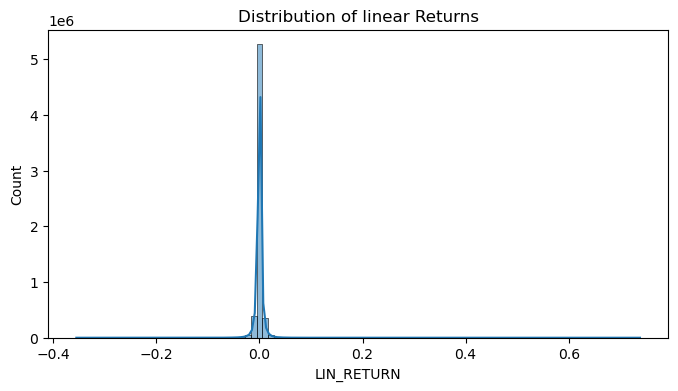

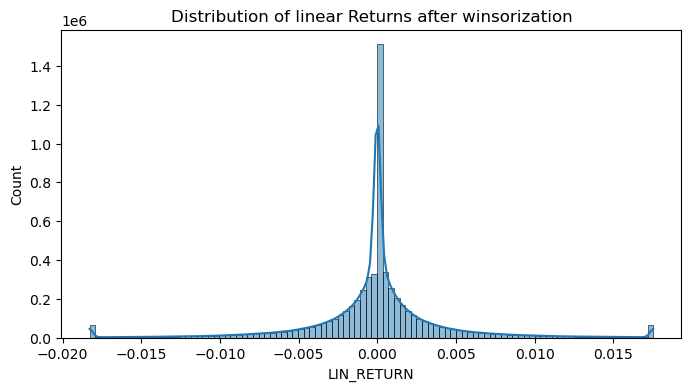

In [7]:
# EDA
print(df["LIN_RETURN"].describe())

# distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["LIN_RETURN"], bins=100, kde=True)
plt.title("Distribution of linear Returns")
plt.show()

# treat the outliers, winsorize
from scipy.stats.mstats import winsorize
df["LIN_RETURN"] = winsorize(df["LIN_RETURN"], limits=[0.01, 0.01])
plt.figure(figsize=(8, 4))
sns.histplot(df["LIN_RETURN"], bins=100, kde=True)
plt.title("Distribution of linear Returns after winsorization")
plt.show()


In [8]:
# Lagged returns, letr's choose the lag size
#TODO:  How to choose the lag size?

In [9]:
df = df.sort_values(by=["SYMBOL", "DATE", "TIME"])

#Regressors
# lagged returns
lags = 5
for lag in range(1, lags + 1):
    df[f"LAG_{lag}"] = df.groupby(["SYMBOL", "DATE"])["LIN_RETURN"].shift(lag)

# rolling mean and std
window_size = 5
df['rolling_mean'] = df.groupby(["SYMBOL", "DATE"])["LIN_RETURN"].rolling(window=window_size, min_periods=1).mean().reset_index(level=[0,1], drop=True)
df['rolling_std'] = df.groupby(["SYMBOL", "DATE"])["LIN_RETURN"].rolling(window=window_size, min_periods=1).std().reset_index(level=[0,1], drop=True)
df = df.dropna(subset=["LIN_RETURN", "rolling_mean", "rolling_std"] + [f"LAG_{lag}" for lag in range(1, lags + 1)])

df

,DATE,SYMBOL,TIME,MID_OPEN,LIN_RETURN,LAG_1,LAG_2,LAG_3,LAG_4,LAG_5,rolling_mean,rolling_std
5,2021-12-01,A,10:20:00,151.790,-0.001119,0.009634,-0.006371,0.006545,-0.011170,0.000000,-0.000496,0.008675
6,2021-12-01,A,10:30:00,151.325,-0.003063,-0.001119,0.009634,-0.006371,0.006545,-0.011170,0.001125,0.006718
7,2021-12-01,A,10:40:00,150.990,-0.002214,-0.003063,-0.001119,0.009634,-0.006371,0.006545,-0.000627,0.006062
8,2021-12-01,A,10:50:00,151.375,0.002550,-0.002214,-0.003063,-0.001119,0.009634,-0.006371,0.001158,0.005200
9,2021-12-01,A,11:00:00,151.180,-0.001288,0.002550,-0.002214,-0.003063,-0.001119,0.009634,-0.001027,0.002146
...,...,...,...,...,...,...,...,...,...,...,...,...
6156353,2021-12-31,ZYXI,15:00:00,10.055,-0.006914,0.005462,0.001492,0.009032,-0.003998,-0.002990,0.001015,0.006562
6156354,2021-12-31,ZYXI,15:10:00,10.040,-0.001492,-0.006914,0.005462,0.001492,0.009032,-0.003998,0.001516,0.006168
6156355,2021-12-31,ZYXI,15:20:00,10.040,0.000000,-0.001492,-0.006914,0.005462,0.001492,0.009032,-0.000290,0.004518
6156356,2021-12-31,ZYXI,15:30:00,10.010,-0.002988,0.000000,-0.001492,-0.006914,0.005462,0.001492,-0.001186,0.004521


In [11]:
train_data = []
test_data = []
train_window_size = 5  # Train on 5 days

# For each stock
for symbol in df['SYMBOL'].unique():
    symbol_data = df[df['SYMBOL'] == symbol]
    unique_dates = symbol_data['DATE'].unique()
    
    # Loop through the dates
    for day in range(len(unique_dates) - train_window_size):
        # Train on days i to i+4 (the end index is exclusive), test on day i+5
        train_dates = unique_dates[day:day + train_window_size]
        test_date = unique_dates[day + train_window_size]
        
        # Filter the data into sets
        train_symbol_data = symbol_data[symbol_data['DATE'].isin(train_dates)]
        test_symbol_data = symbol_data[symbol_data['DATE'] == test_date]
        
        # lists
        train_data.append(train_symbol_data)
        test_data.append(test_symbol_data)

# Concatenate all the train and test data, train_df contains the training data, and test_df contains the testing data
train_df = pd.concat(train_data)
test_df = pd.concat(test_data)

features = [f"LAG_{lag}" for lag in range(1, lags + 1)] +["rolling_mean", "rolling_std"]
target = "LIN_RETURN"

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]


In [12]:
# OLS regression lin_ret = b0 + b1*lag1 + b2*lag2 + b3*lag3 + b4*lag4 + b5*lag5 + b6*rolling_mean + b7*rolling_std
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
y_pred_ols = ols_model.predict(X_test)
ols_mse = mean_squared_error(y_test, y_pred_ols)
ols_r2 = r2_score(y_test, y_pred_ols)
print(f"OLS MSE: {ols_mse}, R2: {ols_r2}")

# Lasso regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
lasso_r2 = r2_score(y_test, y_pred_lasso)
print(f"Lasso MSE: {lasso_mse}, R2: {lasso_r2}")
# TODO: use differnt alpha values

# Ridge regression
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)
print(f"Ridge MSE: {ridge_mse}, R2: {ridge_r2}")

OLS MSE: 8.543482271035063e-29, R2: 1.0
Lasso MSE: 1.5546425549956703e-05, R2: -5.00121721747071e-06
Ridge MSE: 1.1443021498707228e-09, R2: 0.9999263941496328


In [13]:
# Test
test_df = test_df.copy() 
test_df["OLS_PRED"] = y_pred_ols
test_df["LASSO_PRED"] = y_pred_lasso
test_df["RIDGE_PRED"] = y_pred_ridge

test_df["OLS_SIGNAL"] = test_df["OLS_PRED"].apply(lambda x: 1 if x > 0 else -1)
test_df["LASSO_SIGNAL"] = test_df["LASSO_PRED"].apply(lambda x: 1 if x > 0 else -1)
test_df["RIDGE_SIGNAL"] = test_df["RIDGE_PRED"].apply(lambda x: 1 if x > 0 else -1)

test_df
# Save the test data with predictions
test_df.to_parquet("../../data/high_10m_test.parquet", index = False)

In [14]:
test_df

,DATE,SYMBOL,TIME,MID_OPEN,LIN_RETURN,LAG_1,LAG_2,LAG_3,LAG_4,LAG_5,rolling_mean,rolling_std,OLS_PRED,LASSO_PRED,RIDGE_PRED,OLS_SIGNAL,LASSO_SIGNAL,RIDGE_SIGNAL
1411333,2021-12-08,A,10:20:00,155.060,0.000452,0.000807,-0.001129,0.003820,0.000421,0.000000,0.000874,0.001808,4.516420e-04,0.000011,0.000449,1,1,1
1411334,2021-12-08,A,10:30:00,154.855,-0.001322,0.000452,0.000807,-0.001129,0.003820,0.000421,0.000526,0.002067,-1.322069e-03,0.000011,-0.001310,-1,1,-1
1411335,2021-12-08,A,10:40:00,155.125,0.001744,-0.001322,0.000452,0.000807,-0.001129,0.003820,0.000110,0.001309,1.743567e-03,0.000011,0.001729,1,1,1
1411336,2021-12-08,A,10:50:00,155.160,0.000226,0.001744,-0.001322,0.000452,0.000807,-0.001129,0.000381,0.001114,2.256245e-04,0.000011,0.000224,1,1,1
1411337,2021-12-08,A,11:00:00,155.360,0.001289,0.000226,0.001744,-0.001322,0.000452,0.000807,0.000478,0.001179,1.288992e-03,0.000011,0.001278,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6156353,2021-12-31,ZYXI,15:00:00,10.055,-0.006914,0.005462,0.001492,0.009032,-0.003998,-0.002990,0.001015,0.006562,-6.913580e-03,0.000011,-0.006852,-1,1,-1
6156354,2021-12-31,ZYXI,15:10:00,10.040,-0.001492,-0.006914,0.005462,0.001492,0.009032,-0.003998,0.001516,0.006168,-1.491795e-03,0.000011,-0.001474,-1,1,-1
6156355,2021-12-31,ZYXI,15:20:00,10.040,0.000000,-0.001492,-0.006914,0.005462,0.001492,0.009032,-0.000290,0.004518,-2.255683e-16,0.000011,0.000002,-1,1,1
6156356,2021-12-31,ZYXI,15:30:00,10.010,-0.002988,0.000000,-0.001492,-0.006914,0.005462,0.001492,-0.001186,0.004521,-2.988048e-03,0.000011,-0.002963,-1,1,-1
